In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
train_df = pd.read_csv('train_set.csv',sep='\t')
test_df  =  pd.read_csv('test_a.csv',sep='\t')

D:\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#### 1. 类别-文本长度分析


- 上一篇对新闻句子的统计可以得出，本次赛题给定的文本比较长，每个句子平均由907个字符构成，标准差996，最短的句子长度为2，最长的句子长度为57921。大部分句子的长度都集中在2000以内。呈现长尾分布。

- 本次从每个类别来看:

    - 1.均值大于1000的有类别2、5、6、7、12
    - 2.变异系数 大于1 的类别有2、4、8、10、13.其中除了类别1为1.66，其他均在1.27之内。即类别1的离散程度最大。
    - 3.超过20000字数的基本属于类别1；有极少数类别2、6、9、10也超过了2W字。
    - 4.类别4，11中75%的字数少于800；类别11-13的最大字数不超过1W。


| label | count | mean     | std      | min  | 25%    | 50%   | 75%    | max   | cov      |
| ----- | ----- | -------- | -------- | ---- | ------ | ----- | ------ | ----- | -------- |
| 0     | 38918 | 878.7177 | 859.314  | 12   | 397    | 638   | 1017   | 18587 | 0.977918 |
| 1     | 36945 | 870.3637 | 1451.08  | 9    | 281    | 612   | 1059   | 57921 | 1.667211 |
| 2     | 31425 | 1014.43  | 737.3254 | 2    | 580    | 889   | 1262   | 41894 | 0.726837 |
| 3     | 22133 | 784.7747 | 739.3639 | 17   | 340    | 566   | 966    | 10817 | 0.942135 |
| 4     | 15016 | 649.7056 | 718.7135 | 25   | 293    | 439   | 722    | 14928 | 1.106214 |
| 5     | 12232 | 1116.055 | 910.0397 | 27   | 523    | 859   | 1402   | 15839 | 0.815408 |
| 6     | 9985  | 1249.114 | 1203.525 | 16   | 483    | 907   | 1623   | 25728 | 0.963503 |
| 7     | 8841  | 1157.883 | 942.1019 | 11   | 541    | 994   | 1462   | 14469 | 0.813642 |
| 8     | 7847  | 712.4012 | 898.7616 | 7    | 117    | 403   | 1018.5 | 15271 | 1.261595 |
| 9     | 5878  | 833.6271 | 739.6562 | 17   | 434    | 678   | 994.75 | 23866 | 0.887275 |
| 10    | 4920  | 911.138  | 958.4092 | 14   | 451.75 | 590   | 1040   | 20622 | 1.051881 |
| 11    | 3131  | 608.8898 | 509.8367 | 21   | 267.5  | 464   | 794.5  | 5729  | 0.837322 |
| 12    | 1821  | 1194.969 | 1109.003 | 25   | 402    | 972   | 1489   | 8737  | 0.928059 |
| 13    | 908   | 735.326  | 796.1152 | 26   | 160.75 | 278.5 | 1109.5 | 6399  | 1.08267  |

{'科技': 0, '股票': 1, '体育': 2, '娱乐': 3, '时政': 4, '社会': 5, '教育': 6, '财经': 7, '家居': 8, '游戏': 9, '房产': 10, '时尚': 11, '彩票': 12, '星座': 13}


- 计划：
    - 机器学习添加与长度有关的字段
    - 将机器学习表现十分好的字段作为深度学习的标签，进行多任务学习

In [2]:
train_df['text_len'] = train_df['text'].apply(lambda x: len(x.split(' ')))
test_df['text_len'] = test_df['text'].apply(lambda x: len(x.split(' ')))

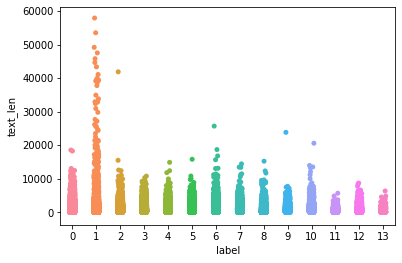

In [3]:
sns.stripplot(x = 'label', y= 'text_len', data = train_df)

#### 2.停用词处理
上一篇可知很多单词大量出现在所有类型的新闻中，对于这部分单词可以删除。

去掉变异系数<0.1的单词:103个。这部分单词在每个类别上出现的概率差不多，可能起不到什么作用。

另外，还观察了变异系数大 且 最大类别出现概率不低于0.8 的几个单词在不用类别中的表现，这部分单词出现在某1-2个类别的概率远大于其他类别，可能是该类别特定词汇。

In [4]:
from collections import Counter
train_df['smp_weights']=train_df.label.apply(lambda x:x+1)
train_sample=train_df.sample(n=20000,weights='smp_weights',random_state=43)

all_lines = ' '.join(list(train_sample['text']))
word_count = Counter(all_lines.split(" "))
word_count = sorted(word_count.items(), key=lambda d:d[1], reverse = True)

word_imp =pd.DataFrame(data=word_count,columns=['word','cnt_tol'])
for i in range(14):
    word_imp['label'+str(i)]=0

In [5]:
for i in range(word_imp.shape[0]):
    tmp = train_sample[train_sample.text.str.contains(word_imp.loc[i]['word'])].groupby('label').text.count()/train_sample.groupby('label').text.count()
    for j in range(14):
        word_imp.loc[i,'label'+str(j)] = tmp[j]

In [6]:
del word_imp['cnt_tol']
word_imp =word_imp.set_index('word')
word_imp = word_imp.T
word_imp=word_imp.fillna(0)

In [7]:
word_des =word_imp.describe().T
word_des['cov']=word_des['std']/word_des['mean']

In [8]:
### 去掉变异系数<0.1的单词:103个
stop_words = word_des[word_des['cov']<0.1].index.tolist()
print(len(stop_words))

103


**去掉停用词后类别-文本长度统计**

In [9]:
train_df['textlen_wostws']=train_df.text.apply(lambda x: len([i for i in x.split(' ') if i not in stop_words]) )

In [12]:
train_df.groupby('label').textlen_wostws.describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
0,38918.0,770.303561,739.321879,12.0,353.0,566.0,895.00,15937.0
1,36945.0,773.800271,1338.503521,9.0,254.0,544.0,937.00,54596.0
2,31425.0,872.313572,643.538379,2.0,501.0,762.0,1081.00,41787.0
3,22133.0,680.601681,631.645851,17.0,299.0,492.0,840.00,9358.0
4,15016.0,571.943261,625.162999,24.0,260.0,390.0,638.00,13320.0
5,12232.0,958.087966,774.541275,27.0,454.0,741.0,1200.00,13799.0
6,9985.0,1092.358938,1059.997424,16.0,428.0,789.0,1406.00,21475.0
7,8841.0,1013.996380,821.464118,11.0,480.0,870.0,1282.00,13380.0
8,7847.0,613.844272,763.261209,7.0,101.0,353.0,880.50,12679.0


- **我们看看变异系数大 且 最大类别出现频率不低于0.8 的几个单词在不用类别中的表现**

还是挺有类别间区分度的

In [79]:
word_imp = word_imp.T
def fun(lst):
    m =max(lst)
    n = np.std(lst)/np.mean(lst)
    return 1 if m>0.8 and n>1 else 0 

word_imp['is_show']=0
for i in word_imp.index.tolist():
    word_imp.loc[i,'is_show']= fun(word_imp.loc[i].tolist())

word_show = word_imp[word_imp['is_show']==1]
show_word = word_show.index.tolist()

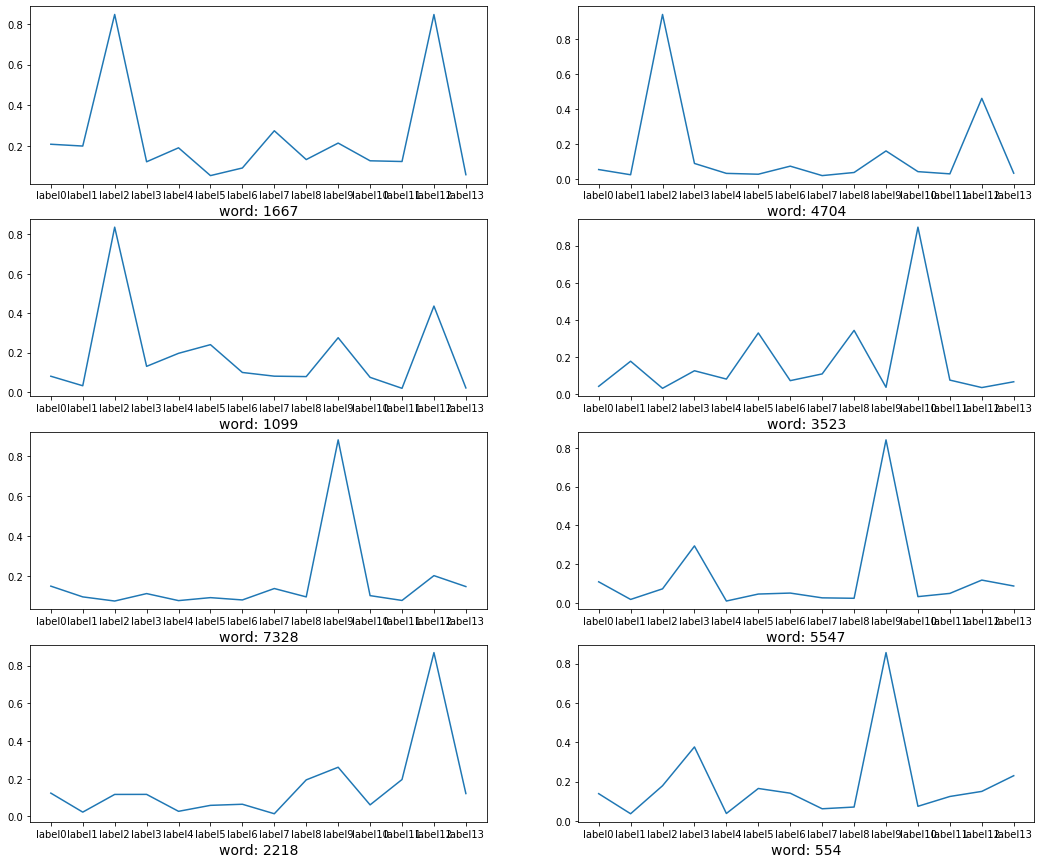

In [141]:
plt.figure(figsize=(18,15))
for i in range(8):
    x=word_show.loc[show_word[i]].index.tolist()[:14]
    y=word_show.loc[show_word[i]].values.tolist()[:14]
    plt.subplot(421+i)
    plt.plot(x,y)
    plt.xlabel('word: '+show_word[i],fontsize=14)
plt.show()


#### 3. 标签-特征相关性分析

